In [20]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math
from pyNBA.Data.constants import BAD_CONTEST_SUBSTRINGS, DB_TEAM_TO_NBA_TEAM, OWNERSHIP_NAME_TO_NBA_NAME
from functools import reduce

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
query_data = QueryData()

# historical DFS contest data. I am only interested in predicting ownership in Classic GPP compeititions.
contest_data = query_data.query_contest_data()
contest_data = contest_data.loc[
    (contest_data['CASHLINE'] > 0) & (contest_data['SLATETYPE'] == 'Classic') & (contest_data['CASHLINE'] > 200) &
    (~contest_data['CONTESTNAME'].str.lower().str.contains('|'.join(BAD_CONTEST_SUBSTRINGS)))
].dropna(subset=['CASHLINE'])
contest_data['MAXROI'] = contest_data['TOPPRIZE']/contest_data['ENTRYFEE']
contest_data = contest_data.loc[contest_data['MAXROI'] > 2]

# historical vegas odds data
odds_data = query_data.query_odds_data()
full_game_odds = odds_data.loc[odds_data['PERIOD'] == 'Full Game']

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [3]:
contest_data['TEAMSLIST'] = contest_data['TEAMS'].apply(lambda x: x.split('_'))
team_contest_data = contest_data.explode('TEAMSLIST').rename(columns={'TEAMSLIST': 'TEAM'})
team_contest_data['TEAM'] = team_contest_data['TEAM'].apply(lambda x: x if x not in DB_TEAM_TO_NBA_TEAM else DB_TEAM_TO_NBA_TEAM[x])
team_contest_data = team_contest_data.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')
team_contest_data = team_contest_data.dropna(subset=['TOTAL'])

In [4]:
contest_average_total = team_contest_data.groupby(['DATE', 'CONTESTID']).apply(
    lambda x: pd.Series({
        'AVERAGE_TOTAL': x['TOTAL'].mean()
    })
).reset_index()
contest_data = contest_data.merge(contest_average_total, on=['DATE', 'CONTESTID'], how='left')

In [5]:
display(contest_data)

,SITE,DATE,SLATEID,SLATETYPE,GAMECOUNT,TEAMS,CONTESTID,CONTESTNAME,PRIZEPOOL,ENTRYFEE,TOPPRIZE,MAXENTRIES,TOTALENTRIES,CASHLINE,TOPSCORE,MAXROI,TEAMSLIST,AVERAGE_TOTAL
0,DRAFTKINGS,2020-03-11,5e6a282ee286d854732c3174,Classic,2,MIA_NYK_ATL_CHA,5e6a282ee286d854732c327d,NBA $20K Excellent 8's [$5K to 1st] (Turbo),20000.0,8.0,5000.0,88.0,2942,301.50,352.50,625.000000,"[MIA, NYK, ATL, CHA]",220.750000
1,DRAFTKINGS,2020-03-11,5e696e13f4053b1dcb589c40,Classic,6,DAL_MIA_NOP_DET_NYK_UTA_PHI_ATL_DEN_SAC_OKC_CHA,5e6a280d3ce272546761b206,NBA $7.5K Pick and Pop [3 Entry Max],7500.0,75.0,1500.0,3.0,114,242.50,316.50,20.000000,"[DAL, MIA, NOP, DET, NYK, UTA, PHI, ATL, DEN, ...",221.666667
2,DRAFTKINGS,2020-03-11,5e696e13f4053b1dcb589c40,Classic,6,DAL_MIA_NOP_DET_NYK_UTA_PHI_ATL_DEN_SAC_OKC_CHA,5e6a280e3ce272546761b33e,NBA $5K Ankle Breaker [3 Entry Max],5000.0,50.0,600.0,3.0,114,265.00,337.75,12.000000,"[DAL, MIA, NOP, DET, NYK, UTA, PHI, ATL, DEN, ...",221.666667
3,DRAFTKINGS,2020-03-11,5e696e13f4053b1dcb589c40,Classic,6,DAL_MIA_NOP_DET_NYK_UTA_PHI_ATL_DEN_SAC_OKC_CHA,5e6a288670cbeb5483f3cc83,NBA $10K Buzzer Beater [3 Entry Max],10000.0,20.0,1000.0,3.0,589,249.00,352.50,50.000000,"[DAL, MIA, NOP, DET, NYK, UTA, PHI, ATL, DEN, ...",221.666667
4,DRAFTKINGS,2020-03-11,5e696e13f4053b1dcb589c40,Classic,6,DAL_MIA_NOP_DET_NYK_UTA_PHI_ATL_DEN_SAC_OKC_CHA,5e6a282570cbeb5483f29c7d,NBA $25K Zone [$5K to 1st],25000.0,5.0,5000.0,150.0,5946,241.25,371.25,1000.000000,"[DAL, MIA, NOP, DET, NYK, UTA, PHI, ATL, DEN, ...",221.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15033,DRAFTKINGS,2017-10-18,5ae4d5805689223dfa12d8ad,Classic,11,MIA_SAS_ORL_BKN_BOS_MIL_DEN_CHA_IND_PHI_DAL_NO...,5ae50c1c085a677335596ae1,NBA $6K Mid-Range Jumper [Single Entry],6000.0,40.0,720.0,1.0,174,279.00,333.00,18.000000,"[MIA, SAS, ORL, BKN, BOS, MIL, DEN, CHA, IND, ...",209.227273
15034,DRAFTKINGS,2017-10-18,5ae4d5805689223dfa12d8ad,Classic,11,MIA_SAS_ORL_BKN_BOS_MIL_DEN_CHA_IND_PHI_DAL_NO...,5ae4d5805689223dfa12da16,NBA $10K Posterizer [2 Entry Max],10000.0,150.0,2000.0,2.0,74,280.75,320.50,13.333333,"[MIA, SAS, ORL, BKN, BOS, MIL, DEN, CHA, IND, ...",209.227273
15035,DRAFTKINGS,2017-10-18,5ae4d5805689223dfa12d8ad,Classic,11,MIA_SAS_ORL_BKN_BOS_MIL_DEN_CHA_IND_PHI_DAL_NO...,5ae4d66ff69c5a3e0026d7ea,NBA $5K Hot Shot [3 Entry Max],5000.0,3.0,500.0,3.0,1981,281.25,358.00,166.666667,"[MIA, SAS, ORL, BKN, BOS, MIL, DEN, CHA, IND, ...",209.227273
15036,DRAFTKINGS,2017-10-18,5ae4d5805689223dfa12d8ad,Classic,11,MIA_SAS_ORL_BKN_BOS_MIL_DEN_CHA_IND_PHI_DAL_NO...,5ae6006bfd67640e26e3a516,NBA $10K Pick & Roll [Single Entry],10000.0,12.0,1000.0,1.0,980,278.75,349.75,83.333333,"[MIA, SAS, ORL, BKN, BOS, MIL, DEN, CHA, IND, ...",209.227273


In [6]:
regressors = ['GAMECOUNT', 'ENTRYFEE', 'TOPPRIZE', 'MAXENTRIES', 'TOTALENTRIES', 'AVERAGE_TOTAL']
y = 'TOPSCORE'
feature_matrix = contest_data[['DATE', 'CONTESTNAME'] + regressors + [y]]

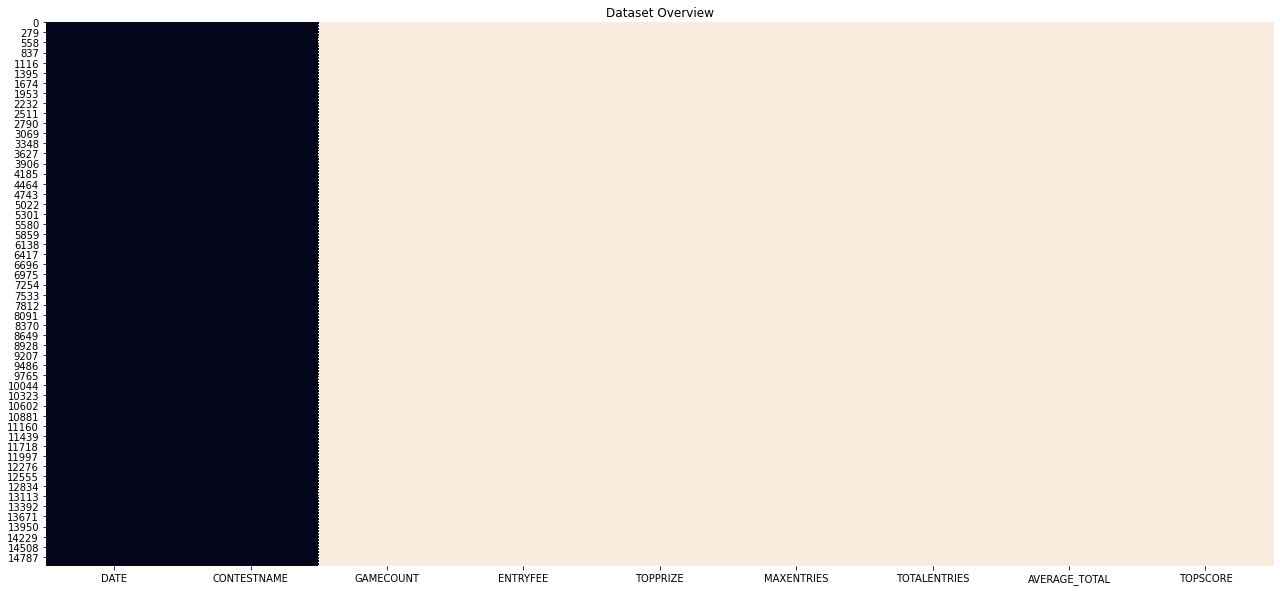

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [11]:
helpers = Helpers()
plt.rcParams["figure.figsize"] = (22, 10)
helpers.visualize_dataframe(feature_matrix)

In [15]:
linear_models = [
    linear_model.LinearRegression()
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformer = {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
}

numeric_regressors = list(set(regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
      
    # transform numeric columns
    temp_feature_matrix = feature_matrix.copy()
    temp_feature_matrix[numeric_columns] = temp_feature_matrix[numeric_columns].apply(
        transformer['Function'], axis=1
    )

    # feature selection
    X = temp_feature_matrix[regressors]
    Y = temp_feature_matrix[y]

    if model in (neighbor_models + neural_networks):
        selected_features = regressors.copy()
    else:
        model.fit(X, Y)

        # importance
        importance_selector = SelectFromModel(model, threshold='0.75*median')
        importance_selector = importance_selector.fit(X, Y)
        importance_support = importance_selector.get_support()

        # rank
        rank_selector = RFE(model)
        rank_selector = rank_selector.fit(X, Y)
        rank_support = rank_selector.ranking_
        median_rank = np.median(rank_support)

        selected_features = []
        for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
            # select the feature if it's important, or has a low rank
            if importance_flag or (rank <= median_rank):
                selected_features.append(feature)

    X = temp_feature_matrix[selected_features].values
    Y = temp_feature_matrix[y].values

    # cross validation
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    for train, test in cv.split(X, Y):
        prediction = model.fit(X[train], Y[train]).predict(X[test])
        true = Y[test]

        prediction = transformer['Inverse Function'](prediction)
        true = transformer['Inverse Function'](true)

        scores.append(metrics.mean_absolute_error(prediction, true))

    mean_score = np.mean(scores)
    print('\nModel:', model)
    print('Transformer:', transformer['Name'])
    print('Selected Features:', selected_features)
    print('Mean MAE:', mean_score)
    if mean_score < min_score:
        min_score = mean_score
        best_model = (model, transformer['Name'], selected_features)

print()
print(best_model, min_score)


Model: LinearRegression()
Transformer: None
Selected Features: ['GAMECOUNT', 'MAXENTRIES', 'AVERAGE_TOTAL']
Mean MAE: 21.387289181379785

Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)
Transformer: None
Selected Features: ['GAMECOUNT', 'TOTALENTRIES', 'AVERAGE_TOTAL']
Mean MAE: 11.996223223963375

Model: <catboost.core.CatBoostRegressor object at 0x12fc794a8>
Transformer: None
Selected Features: ['GAMECOUNT', 'TOTALENTRIES', 'AVERAGE_TOTAL']
Mean MAE:

In [16]:
selected_features =  ['GAMECOUNT', 'TOTALENTRIES', 'AVERAGE_TOTAL']
X = feature_matrix[selected_features]
Y = feature_matrix[y]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [17]:
model = xgb.XGBRegressor()

model_params = {
    'max_depth': [4, 6, 8, 10],
    'eta' : [0.01, 0.02, 0.05, 0.1],
    'n_estimators': [5000],
    'eval_metric': ['mae'],
    'tree_method': ['hist']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": [(X_test, y_test)]
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

[0]	validation_0-mae:321.28171
Will train until validation_0-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:305.24341
[2]	validation_0-mae:290.00174
[3]	validation_0-mae:275.52103
[4]	validation_0-mae:261.76086
[5]	validation_0-mae:248.69035
[6]	validation_0-mae:236.27896
[7]	validation_0-mae:224.48322
[8]	validation_0-mae:213.27463
[9]	validation_0-mae:202.63275
[10]	validation_0-mae:192.51916
[11]	validation_0-mae:182.91725
[12]	validation_0-mae:173.78989
[13]	validation_0-mae:165.10310
[14]	validation_0-mae:156.86307
[15]	validation_0-mae:149.05225
[16]	validation_0-mae:141.60292
[17]	validation_0-mae:134.54460
[18]	validation_0-mae:127.82580
[19]	validation_0-mae:121.46277
[20]	validation_0-mae:115.40423
[21]	validation_0-mae:109.64863
[22]	validation_0-mae:104.18672
[23]	validation_0-mae:98.99038
[24]	validation_0-mae:94.05547
[25]	validation_0-mae:89.36540
[26]	validation_0-mae:84.92107
[27]	validation_0-mae:80.69498
[28]	validation_0-mae:76.68877
[29]	validation_0-mae:72

[257]	validation_0-mae:13.93592
[258]	validation_0-mae:13.93656
[259]	validation_0-mae:13.93430
[260]	validation_0-mae:13.92874
[261]	validation_0-mae:13.92690
[262]	validation_0-mae:13.92491
[263]	validation_0-mae:13.92231
[264]	validation_0-mae:13.90816
[265]	validation_0-mae:13.90691
[266]	validation_0-mae:13.90756
[267]	validation_0-mae:13.89820
[268]	validation_0-mae:13.89026
[269]	validation_0-mae:13.88545
[270]	validation_0-mae:13.88622
[271]	validation_0-mae:13.88012
[272]	validation_0-mae:13.86440
[273]	validation_0-mae:13.86280
[274]	validation_0-mae:13.86349
[275]	validation_0-mae:13.84806
[276]	validation_0-mae:13.84739
[277]	validation_0-mae:13.83001
[278]	validation_0-mae:13.82592
[279]	validation_0-mae:13.81761
[280]	validation_0-mae:13.78806
[281]	validation_0-mae:13.78437
[282]	validation_0-mae:13.77380
[283]	validation_0-mae:13.75959
[284]	validation_0-mae:13.74634
[285]	validation_0-mae:13.73176
[286]	validation_0-mae:13.72876
[287]	validation_0-mae:13.72039
[288]	va

[514]	validation_0-mae:12.59218
[515]	validation_0-mae:12.58644
[516]	validation_0-mae:12.58183
[517]	validation_0-mae:12.57626
[518]	validation_0-mae:12.57022
[519]	validation_0-mae:12.56672
[520]	validation_0-mae:12.56247
[521]	validation_0-mae:12.55799
[522]	validation_0-mae:12.55502
[523]	validation_0-mae:12.54754
[524]	validation_0-mae:12.54237
[525]	validation_0-mae:12.54203
[526]	validation_0-mae:12.54192
[527]	validation_0-mae:12.54139
[528]	validation_0-mae:12.52589
[529]	validation_0-mae:12.52410
[530]	validation_0-mae:12.51259
[531]	validation_0-mae:12.51013
[532]	validation_0-mae:12.51010
[533]	validation_0-mae:12.49618
[534]	validation_0-mae:12.48888
[535]	validation_0-mae:12.47734
[536]	validation_0-mae:12.47865
[537]	validation_0-mae:12.47786
[538]	validation_0-mae:12.47595
[539]	validation_0-mae:12.46638
[540]	validation_0-mae:12.46601
[541]	validation_0-mae:12.46598
[542]	validation_0-mae:12.46585
[543]	validation_0-mae:12.46697
[544]	validation_0-mae:12.46311
[545]	va

[771]	validation_0-mae:12.03061
[772]	validation_0-mae:12.02342
[773]	validation_0-mae:12.02410
[774]	validation_0-mae:12.02564
[775]	validation_0-mae:12.02535
[776]	validation_0-mae:12.02356
[777]	validation_0-mae:12.02426
[778]	validation_0-mae:12.02507
[779]	validation_0-mae:12.01939
[780]	validation_0-mae:12.01937
[781]	validation_0-mae:12.01944
[782]	validation_0-mae:12.01922
[783]	validation_0-mae:12.01907
[784]	validation_0-mae:12.01985
[785]	validation_0-mae:12.01970
[786]	validation_0-mae:12.01562
[787]	validation_0-mae:12.01608
[788]	validation_0-mae:12.00980
[789]	validation_0-mae:12.00960
[790]	validation_0-mae:12.00716
[791]	validation_0-mae:12.00660
[792]	validation_0-mae:12.00106
[793]	validation_0-mae:12.00175
[794]	validation_0-mae:11.99890
[795]	validation_0-mae:11.99564
[796]	validation_0-mae:11.99478
[797]	validation_0-mae:11.99486
[798]	validation_0-mae:11.99437
[799]	validation_0-mae:11.99292
[800]	validation_0-mae:11.99289
[801]	validation_0-mae:11.98827
[802]	va

In [18]:
best_params = grid.best_params_
model = xgb.XGBRegressor(**best_params)

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

[0]	validation_0-mae:321.28171
Will train until validation_0-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:305.24344
[2]	validation_0-mae:290.00177
[3]	validation_0-mae:275.52103
[4]	validation_0-mae:261.76086
[5]	validation_0-mae:248.69035
[6]	validation_0-mae:236.27896
[7]	validation_0-mae:224.48323
[8]	validation_0-mae:213.27463
[9]	validation_0-mae:202.63275
[10]	validation_0-mae:192.51916
[11]	validation_0-mae:182.91724
[12]	validation_0-mae:173.78989
[13]	validation_0-mae:165.10312
[14]	validation_0-mae:156.86307
[15]	validation_0-mae:149.05225
[16]	validation_0-mae:141.60292
[17]	validation_0-mae:134.54460
[18]	validation_0-mae:127.82580
[19]	validation_0-mae:121.46277
[20]	validation_0-mae:115.40423
[21]	validation_0-mae:109.64862
[22]	validation_0-mae:104.18672
[23]	validation_0-mae:98.99040
[24]	validation_0-mae:94.05547
[25]	validation_0-mae:89.36540
[26]	validation_0-mae:84.92107
[27]	validation_0-mae:80.69498
[28]	validation_0-mae:76.68875
[29]	validation_0-mae:72

[257]	validation_0-mae:13.93592
[258]	validation_0-mae:13.93656
[259]	validation_0-mae:13.93430
[260]	validation_0-mae:13.92874
[261]	validation_0-mae:13.92690
[262]	validation_0-mae:13.92491
[263]	validation_0-mae:13.92231
[264]	validation_0-mae:13.90816
[265]	validation_0-mae:13.90691
[266]	validation_0-mae:13.90756
[267]	validation_0-mae:13.89820
[268]	validation_0-mae:13.89026
[269]	validation_0-mae:13.88545
[270]	validation_0-mae:13.88622
[271]	validation_0-mae:13.88012
[272]	validation_0-mae:13.86440
[273]	validation_0-mae:13.86280
[274]	validation_0-mae:13.86349
[275]	validation_0-mae:13.84806
[276]	validation_0-mae:13.84739
[277]	validation_0-mae:13.83001
[278]	validation_0-mae:13.82592
[279]	validation_0-mae:13.81761
[280]	validation_0-mae:13.78806
[281]	validation_0-mae:13.78437
[282]	validation_0-mae:13.77380
[283]	validation_0-mae:13.75959
[284]	validation_0-mae:13.74634
[285]	validation_0-mae:13.73176
[286]	validation_0-mae:13.72876
[287]	validation_0-mae:13.72039
[288]	va

[514]	validation_0-mae:12.59218
[515]	validation_0-mae:12.58644
[516]	validation_0-mae:12.58183
[517]	validation_0-mae:12.57626
[518]	validation_0-mae:12.57022
[519]	validation_0-mae:12.56672
[520]	validation_0-mae:12.56247
[521]	validation_0-mae:12.55799
[522]	validation_0-mae:12.55502
[523]	validation_0-mae:12.54754
[524]	validation_0-mae:12.54237
[525]	validation_0-mae:12.54203
[526]	validation_0-mae:12.54192
[527]	validation_0-mae:12.54139
[528]	validation_0-mae:12.52589
[529]	validation_0-mae:12.52410
[530]	validation_0-mae:12.51259
[531]	validation_0-mae:12.51013
[532]	validation_0-mae:12.51010
[533]	validation_0-mae:12.49618
[534]	validation_0-mae:12.48888
[535]	validation_0-mae:12.47734
[536]	validation_0-mae:12.47864
[537]	validation_0-mae:12.47786
[538]	validation_0-mae:12.47595
[539]	validation_0-mae:12.46638
[540]	validation_0-mae:12.46601
[541]	validation_0-mae:12.46598
[542]	validation_0-mae:12.46585
[543]	validation_0-mae:12.46697
[544]	validation_0-mae:12.46311
[545]	va

[771]	validation_0-mae:12.03061
[772]	validation_0-mae:12.02342
[773]	validation_0-mae:12.02410
[774]	validation_0-mae:12.02564
[775]	validation_0-mae:12.02535
[776]	validation_0-mae:12.02356
[777]	validation_0-mae:12.02426
[778]	validation_0-mae:12.02507
[779]	validation_0-mae:12.01939
[780]	validation_0-mae:12.01937
[781]	validation_0-mae:12.01944
[782]	validation_0-mae:12.01922
[783]	validation_0-mae:12.01907
[784]	validation_0-mae:12.01985
[785]	validation_0-mae:12.01970
[786]	validation_0-mae:12.01562
[787]	validation_0-mae:12.01608
[788]	validation_0-mae:12.00980
[789]	validation_0-mae:12.00960
[790]	validation_0-mae:12.00716
[791]	validation_0-mae:12.00660
[792]	validation_0-mae:12.00106
[793]	validation_0-mae:12.00175
[794]	validation_0-mae:11.99890
[795]	validation_0-mae:11.99564
[796]	validation_0-mae:11.99478
[797]	validation_0-mae:11.99486
[798]	validation_0-mae:11.99437
[799]	validation_0-mae:11.99292
[800]	validation_0-mae:11.99289
[801]	validation_0-mae:11.98827
[802]	va

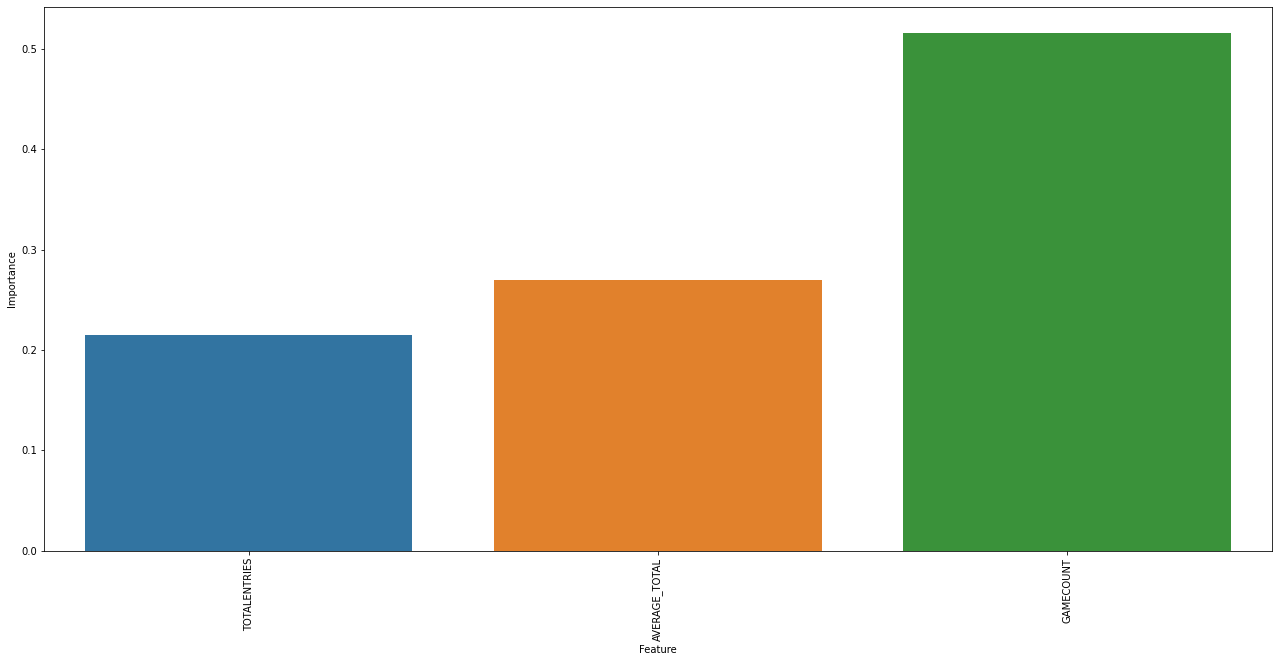

In [21]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [22]:
# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat)), 6))

R2 (explained variance):
Model: 0.722

Mean Absolute Error (Σ|y-pred|/n):
Model: 11.847289

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 16.465596


No handles with labels found to put in legend.
No handles with labels found to put in legend.


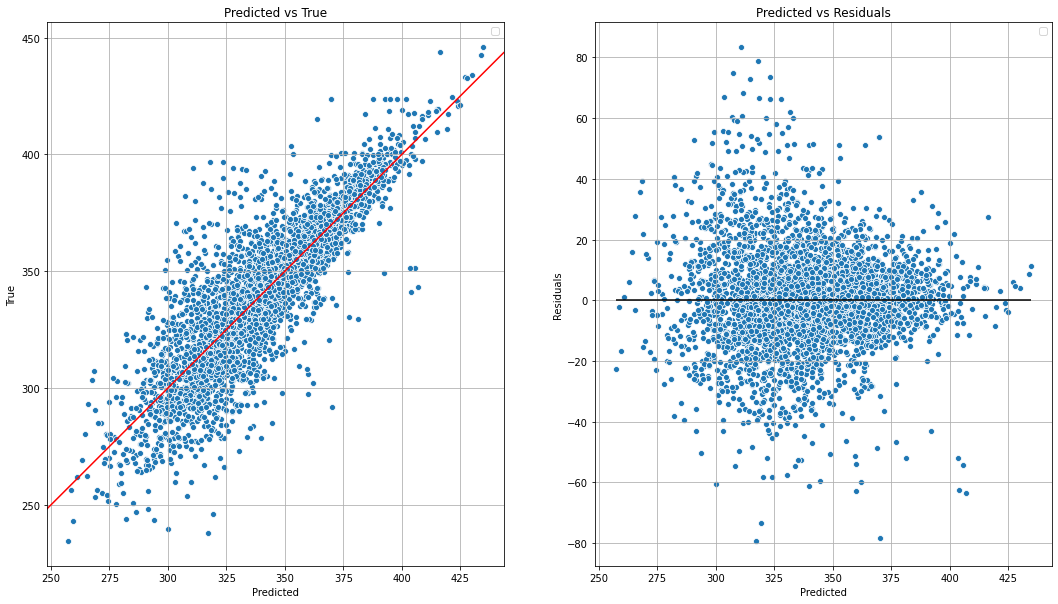

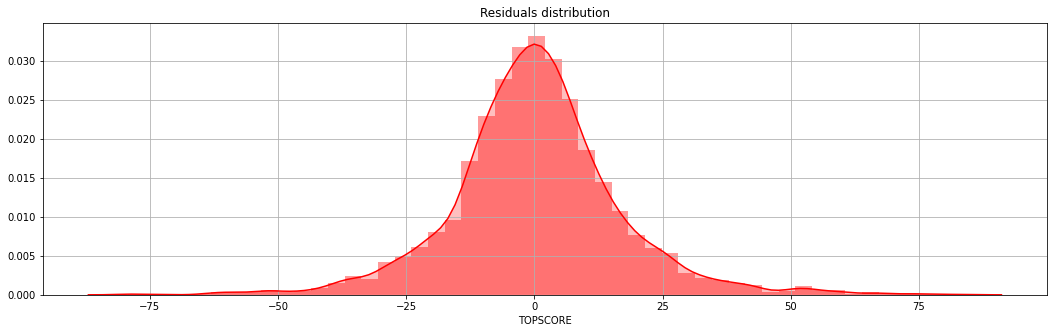

In [23]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()